In [1]:
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
class ImageRotation(Dataset):
    def __init__(self, root, split, img_transforms):
        csv_file = pd.read_csv(os.path.join(root, f"{split}.csv"))

        image_ids = csv_file["image_id"].to_numpy()
        self.img_transforms = img_transforms
        
        images_path = os.path.join(root, f"{split}_images")
        self.data = []
        for img_id in image_ids:
            img = cv2.imread(os.path.join(images_path, f"{img_id}.jpg"))
            self.data.append(img)

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        sample_img = self.data[idx]
        sample_img = self.img_transforms(sample_img)

        return sample_img

In [64]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
            
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(self.maxpool(x))

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.use_dropout = dropout
            
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.conv(self.up(x))
        return self.dropout(out) if self.use_dropout else out

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.down1 = Downsample(in_channels=16, out_channels=32)
        self.down2 = Downsample(in_channels=32, out_channels=32)
        self.down3 = Downsample(in_channels=32, out_channels=64)
        # self.down4 = Downsample(in_channels=128, out_channels=256)

        self.up1 = Upsample(in_channels=64, out_channels=32, dropout=True)
        self.up2 = Upsample(in_channels=32, out_channels=32, dropout=True)
        self.up3 = Upsample(in_channels=32, out_channels=16, dropout=True)
        # self.up4 = Upsample(in_channels=32, out_channels=16, dropout=False)

        self.last_conv = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # print(x.shape)
        x = self.init_conv(x)
        # print(x.shape)
        x = self.down1(x)
        # print(x.shape)
        x = self.down2(x)
        # print(x.shape)
        x = self.down3(x)
        # print(x.shape)
        # x = self.down4(x)
        # print(x.shape)

        
        features = x
        
        x = self.up1(x)
        # print(x.shape)
        x = self.up2(x)
        # print(x.shape)
        x = self.up3(x)
        # print(x.shape)
        # x = self.up4(x)
        # print(x.shape)
        
        x = self.last_conv(x)
        # print(x.shape)
        return x, features
        
        

In [74]:
batch_size = 64
lr = 2e-4
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

root = "/kaggle/input/image-sentence-pair-v2"

img_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((96, 96))
])

train_dataset = ImageRotation(root, "train", img_transforms)
val_dataset = ImageRotation(root, "val", img_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [75]:
img = next(iter(train_dataloader))
model = Autoencoder()
y = model(img)

In [76]:
def train_step(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0

    for img_inputs in tqdm(train_loader):
        img_inputs = img_inputs.to(device)
        
        optimizer.zero_grad()
        
        outputs, _ = model(img_inputs)
        loss = loss_fn(outputs, img_inputs)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_step_loss = total_loss / len(train_loader)
    return train_step_loss

def val_step(model, val_loader, optimizer, loss_fn):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for img_inputs in tqdm(val_loader):
            img_inputs = img_inputs.to(device)

            outputs, _ = model(img_inputs)
            loss = loss_fn(outputs, img_inputs)
    
            total_loss += loss.item()

    val_step_loss = total_loss / len(val_loader)

    return val_step_loss

def visualize(model, val_dataloader):
    model.eval()

    x = next(iter(val_dataloader))
    x = x.to(device)
    
    with torch.no_grad():
        y, _ = model(x)
    
    # put them on cpu
    x = x.cpu()
    y = y.detach().cpu()
    
    # denormalize
    x = x * 0.5 + 0.5
    y = y * 0.5 + 0.5
    
    # plot images
    fig = plt.figure()
    
    fig.add_subplot(1, 2, 1) 

    plt.imshow(x[0].permute(1, 2, 0)) 
    plt.axis('off') 
    plt.title("x") 

    fig.add_subplot(1, 2, 2) 

    plt.imshow(y[0].permute(1, 2, 0)) 
    plt.axis('off') 
    plt.title("y")
        
    plt.show()

def train():
    model = Autoencoder().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()

    best_loss = 100.0
    best_model = None

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_step_loss = train_step(model, train_dataloader, optimizer, loss_fn)
        print(f"train_step_loss: {train_step_loss}")
        
        val_step_loss= val_step(model, val_dataloader, optimizer, loss_fn)
        print(f"val_step_loss: {val_step_loss}")

        train_losses.append(train_step_loss)
        val_losses.append(val_step_loss)

        if val_step_loss < best_loss:
            best_loss = val_step_loss
            torch.save(model.state_dict(), "best_autoencoder.pt")
            visualize(model, val_dataloader)
            

    plt.plot(range(epochs), train_losses)
    plt.title("Train loss")
    plt.savefig("train_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_losses)
    plt.title("Val loss")
    plt.savefig("val_loss.jpg")
    plt.plot()

epoch: 1


100%|██████████| 157/157 [00:08<00:00, 18.27it/s]


train_step_loss: 0.16106395717639072


100%|██████████| 47/47 [00:01<00:00, 30.58it/s]


val_step_loss: 0.08657765451897965


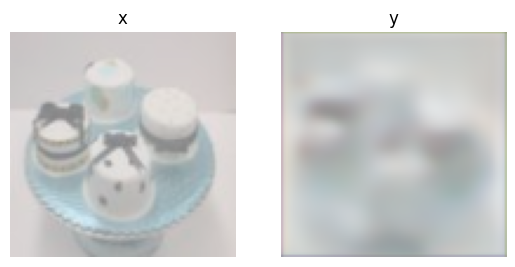

epoch: 2


100%|██████████| 157/157 [00:08<00:00, 18.49it/s]


train_step_loss: 0.10668023889231834


100%|██████████| 47/47 [00:01<00:00, 28.51it/s]


val_step_loss: 0.08016099828354856


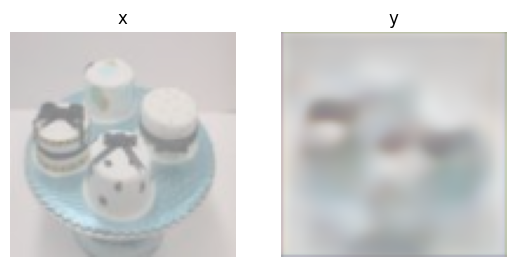

epoch: 3


100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


train_step_loss: 0.09802488655231562


100%|██████████| 47/47 [00:01<00:00, 30.55it/s]


val_step_loss: 0.07784993027118926


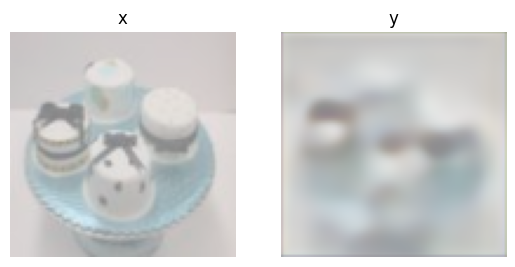

epoch: 4


100%|██████████| 157/157 [00:08<00:00, 18.50it/s]


train_step_loss: 0.0933327047972922


100%|██████████| 47/47 [00:01<00:00, 30.86it/s]


val_step_loss: 0.0832624115208362
epoch: 5


100%|██████████| 157/157 [00:08<00:00, 18.55it/s]


train_step_loss: 0.09004531895658772


100%|██████████| 47/47 [00:01<00:00, 31.01it/s]


val_step_loss: 0.06896068678891405


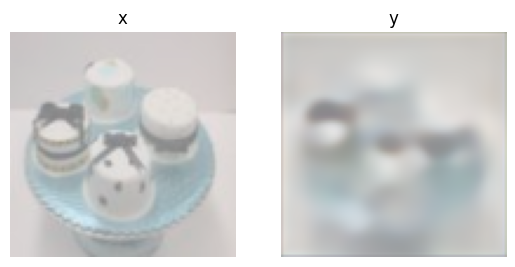

epoch: 6


100%|██████████| 157/157 [00:08<00:00, 18.55it/s]


train_step_loss: 0.08702512797276685


100%|██████████| 47/47 [00:01<00:00, 30.41it/s]


val_step_loss: 0.06714450774040628


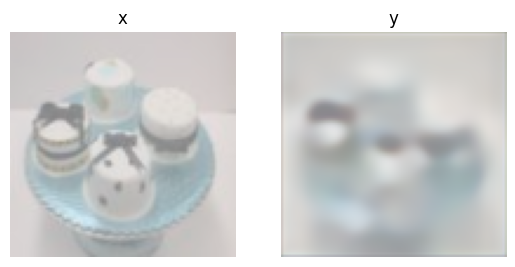

epoch: 7


100%|██████████| 157/157 [00:08<00:00, 18.48it/s]


train_step_loss: 0.08418347069602104


100%|██████████| 47/47 [00:01<00:00, 30.91it/s]


val_step_loss: 0.06542069789894084


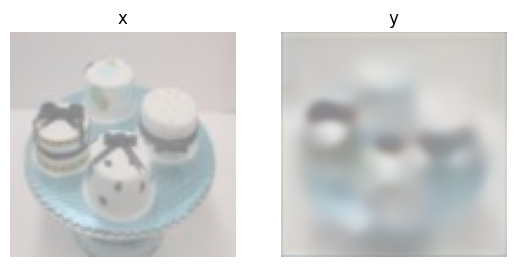

epoch: 8


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.08254693524473032


100%|██████████| 47/47 [00:01<00:00, 30.98it/s]


val_step_loss: 0.06522827476580093


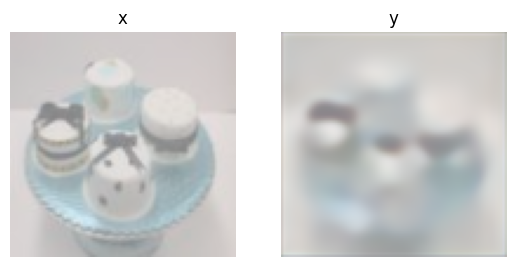

epoch: 9


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.08215617393232455


100%|██████████| 47/47 [00:01<00:00, 30.62it/s]


val_step_loss: 0.06559718225864654
epoch: 10


100%|██████████| 157/157 [00:08<00:00, 18.39it/s]


train_step_loss: 0.0797466782342856


100%|██████████| 47/47 [00:01<00:00, 30.84it/s]


val_step_loss: 0.06424022315347448


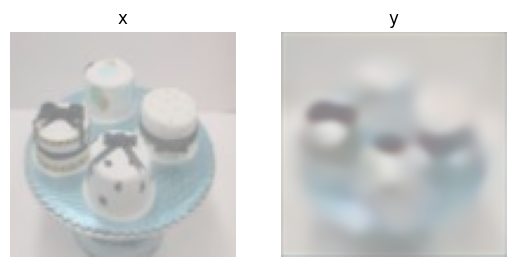

epoch: 11


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.07797933312927842


100%|██████████| 47/47 [00:01<00:00, 30.67it/s]


val_step_loss: 0.06313221869950598


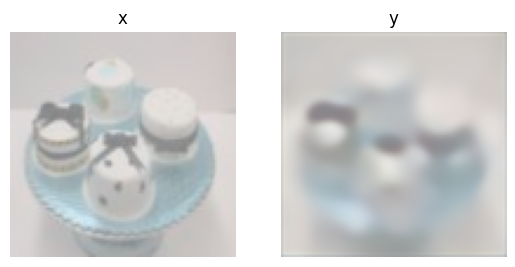

epoch: 12


100%|██████████| 157/157 [00:08<00:00, 18.49it/s]


train_step_loss: 0.07711608257073506


100%|██████████| 47/47 [00:01<00:00, 30.50it/s]


val_step_loss: 0.06263108575280676


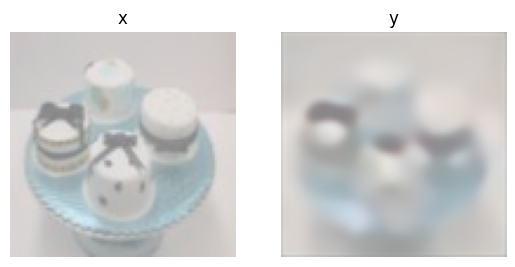

epoch: 13


100%|██████████| 157/157 [00:08<00:00, 18.44it/s]


train_step_loss: 0.07578096116424367


100%|██████████| 47/47 [00:01<00:00, 30.55it/s]


val_step_loss: 0.061977089798830924


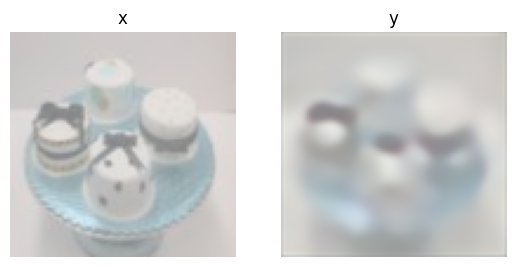

epoch: 14


100%|██████████| 157/157 [00:08<00:00, 18.46it/s]


train_step_loss: 0.07539841048656755


100%|██████████| 47/47 [00:01<00:00, 30.75it/s]


val_step_loss: 0.06091108926116152


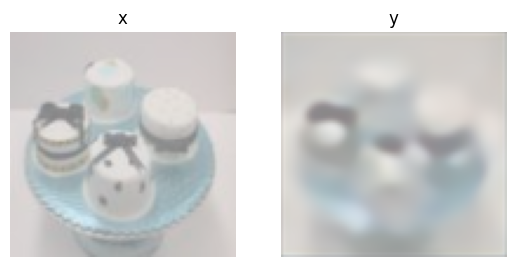

epoch: 15


100%|██████████| 157/157 [00:08<00:00, 18.48it/s]


train_step_loss: 0.07451376954841006


100%|██████████| 47/47 [00:01<00:00, 31.10it/s]


val_step_loss: 0.060403365007740385


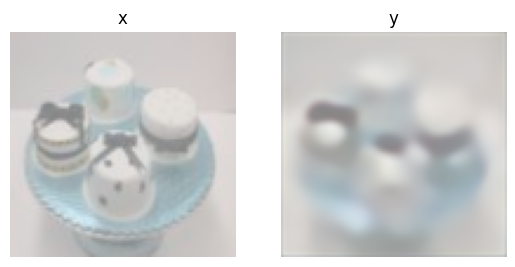

epoch: 16


100%|██████████| 157/157 [00:08<00:00, 18.52it/s]


train_step_loss: 0.07380864028907885


100%|██████████| 47/47 [00:01<00:00, 30.70it/s]


val_step_loss: 0.06043438034805846
epoch: 17


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.07357998790255019


100%|██████████| 47/47 [00:01<00:00, 30.87it/s]


val_step_loss: 0.05914572887915246


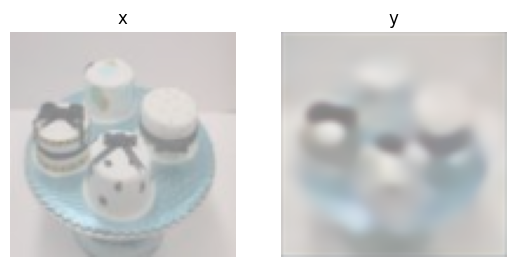

epoch: 18


100%|██████████| 157/157 [00:08<00:00, 18.45it/s]


train_step_loss: 0.0722262088660222


100%|██████████| 47/47 [00:01<00:00, 30.60it/s]


val_step_loss: 0.058574301606797156


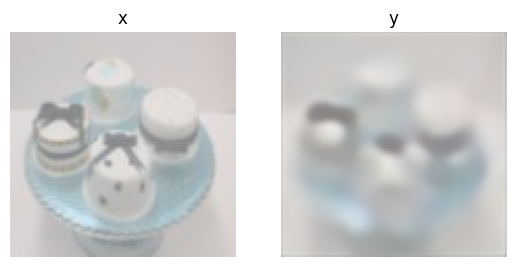

epoch: 19


100%|██████████| 157/157 [00:08<00:00, 18.33it/s]


train_step_loss: 0.0713917068709993


100%|██████████| 47/47 [00:01<00:00, 30.54it/s]


val_step_loss: 0.05990991115253022
epoch: 20


100%|██████████| 157/157 [00:08<00:00, 18.42it/s]


train_step_loss: 0.07224152925287843


100%|██████████| 47/47 [00:01<00:00, 31.02it/s]


val_step_loss: 0.05811596574618461


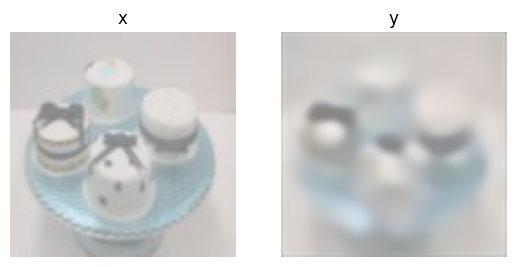

epoch: 21


100%|██████████| 157/157 [00:08<00:00, 18.50it/s]


train_step_loss: 0.07045227868162143


100%|██████████| 47/47 [00:01<00:00, 31.08it/s]


val_step_loss: 0.0587744765142177
epoch: 22


100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


train_step_loss: 0.06989447240996513


100%|██████████| 47/47 [00:01<00:00, 30.97it/s]


val_step_loss: 0.05798678504342728


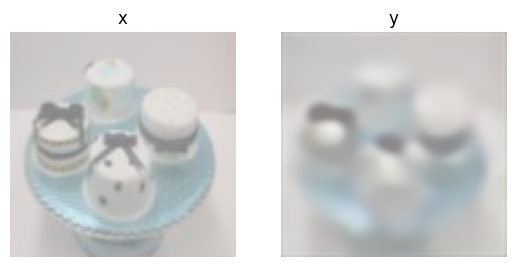

epoch: 23


100%|██████████| 157/157 [00:08<00:00, 18.63it/s]


train_step_loss: 0.06999217396139339


100%|██████████| 47/47 [00:01<00:00, 30.98it/s]


val_step_loss: 0.05928276082936754
epoch: 24


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.06950776074912138


100%|██████████| 47/47 [00:01<00:00, 30.95it/s]


val_step_loss: 0.05820762366056442
epoch: 25


100%|██████████| 157/157 [00:08<00:00, 18.52it/s]


train_step_loss: 0.06832184784921111


100%|██████████| 47/47 [00:01<00:00, 30.90it/s]


val_step_loss: 0.05680383115689805


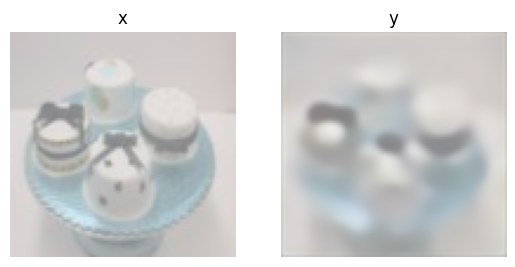

epoch: 26


100%|██████████| 157/157 [00:08<00:00, 18.46it/s]


train_step_loss: 0.06823092352622634


100%|██████████| 47/47 [00:01<00:00, 30.89it/s]


val_step_loss: 0.05656282809820581


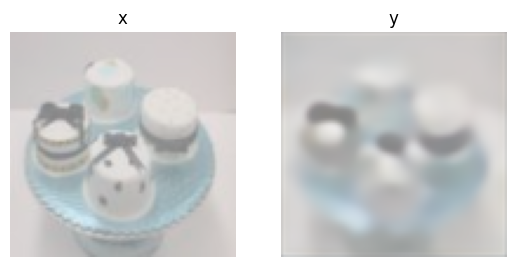

epoch: 27


100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


train_step_loss: 0.06798296818023275


100%|██████████| 47/47 [00:01<00:00, 31.00it/s]


val_step_loss: 0.056083399089092906


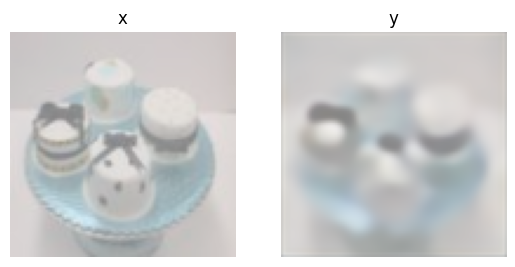

epoch: 28


100%|██████████| 157/157 [00:08<00:00, 18.35it/s]


train_step_loss: 0.06775459917677436


100%|██████████| 47/47 [00:01<00:00, 30.42it/s]


val_step_loss: 0.05574521065709439


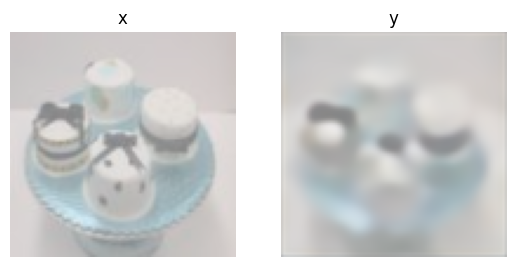

epoch: 29


100%|██████████| 157/157 [00:08<00:00, 18.45it/s]


train_step_loss: 0.06665486714262871


100%|██████████| 47/47 [00:01<00:00, 30.71it/s]


val_step_loss: 0.055548670285559716


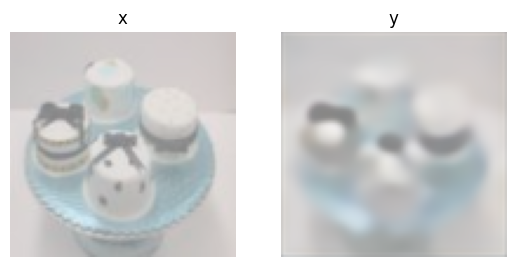

epoch: 30


100%|██████████| 157/157 [00:08<00:00, 18.42it/s]


train_step_loss: 0.06645065807043367


100%|██████████| 47/47 [00:01<00:00, 30.81it/s]


val_step_loss: 0.05517216256641327


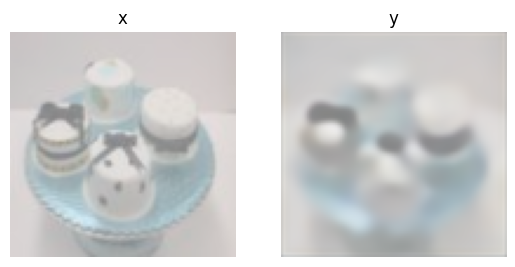

epoch: 31


100%|██████████| 157/157 [00:08<00:00, 18.36it/s]


train_step_loss: 0.06621793769062705


100%|██████████| 47/47 [00:01<00:00, 30.25it/s]


val_step_loss: 0.054793664749632494


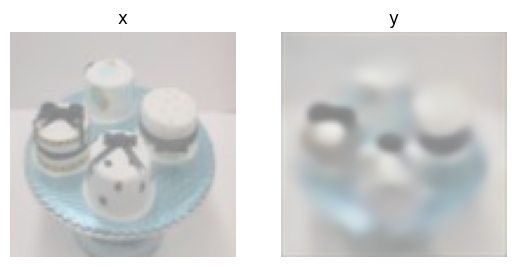

epoch: 32


100%|██████████| 157/157 [00:08<00:00, 18.39it/s]


train_step_loss: 0.0661204553381273


100%|██████████| 47/47 [00:01<00:00, 30.70it/s]


val_step_loss: 0.05457610446721949


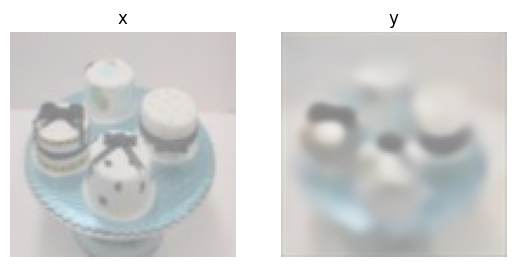

epoch: 33


100%|██████████| 157/157 [00:08<00:00, 18.33it/s]


train_step_loss: 0.06567390272571783


100%|██████████| 47/47 [00:01<00:00, 30.55it/s]


val_step_loss: 0.05508462910322433
epoch: 34


 66%|██████▌   | 104/157 [00:05<00:02, 18.20it/s]

In [ ]:
train()